In [14]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
# Authors: Maxime Goffart and Olivier Joris

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy import stats
from scipy.signal import find_peaks

In [15]:
def load_data(data_path):
    """
    Load the data for the classifer.
    Method given with the assignment. Authors: Antonio Sutera & Yann Claess.

    Argument:
    ---------
    - `data_path`: Path to the data folder.
    """

    FEATURES = range(2, 33)
    N_TIME_SERIES = 3500

    # Create the training and testing samples
    LS_path = os.path.join(data_path, 'LS')
    TS_path = os.path.join(data_path, 'TS')
    X_train, X_test = [np.zeros((N_TIME_SERIES, (len(FEATURES) * 512))) for i in range(2)]

    for f in FEATURES:
        print("Loading feature {}...".format(f))
        data = np.loadtxt(os.path.join(LS_path, 'LS_sensor_{}.txt'.format(f)))
        X_train[:, (f-2)*512:(f-2+1)*512] = data
        data = np.loadtxt(os.path.join(TS_path, 'TS_sensor_{}.txt'.format(f)))
        X_test[:, (f-2)*512:(f-2+1)*512] = data
    
    y_train = np.loadtxt(os.path.join(LS_path, 'activity_Id.txt'))

    print('X_train size: {}.'.format(X_train.shape))
    print('y_train size: {}.'.format(y_train.shape))
    print('X_test size: {}.'.format(X_test.shape))

    return X_train, y_train, X_test

def write_submission(y, where, submission_name='toy_submission.csv'):
    """
    Method given with the assignment. Authors: Antonio Sutera & Yann Claess.

    Arguments:
    ----------
    - `y`: Predictions to write.
    - `where`: Path to the file in which to write.
    - `submission_name`: Name of the file.
    """

    os.makedirs(where, exist_ok=True)

    SUBMISSION_PATH = os.path.join(where, submission_name)
    if os.path.exists(SUBMISSION_PATH):
        os.remove(SUBMISSION_PATH)

    y = y.astype(int)
    outputs = np.unique(y)

    # Verify conditions on the predictions
    if np.max(outputs) > 14:
        raise ValueError('Class {} does not exist.'.format(np.max(outputs)))
    if np.min(outputs) < 1:
        raise ValueError('Class {} does not exist.'.format(np.min(outputs)))
    
    # Write submission file
    with open(SUBMISSION_PATH, 'a') as file:
        n_samples = len(y)
        if n_samples != 3500:
            raise ValueError('Check the number of predicted values.')

        file.write('Id,Prediction\n')

        for n, i in enumerate(y):
            file.write('{},{}\n'.format(n+1, int(i)))

    print('Submission {} saved in {}.'.format(submission_name, SUBMISSION_PATH))

In [18]:
def feature_extraction(X_train, X_test, data_path):
    """
    Feature extraction.

    Arguments:
    ----------
    - `X_train`: Inputs of LS.
    - `X_test`: Inputs of TS.
    
    Return:
    -------
    Inputs of LS and TS after feature extraction.
    """

    FEATURES = range(2, 33)
    N_TIME_SERIES = 3500
    N_ATTRIBUTES = 16

    LS_path = os.path.join(data_path, 'LS')
    TS_path = os.path.join(data_path, 'TS')

    new_X_train = np.zeros((N_TIME_SERIES, len(FEATURES) * N_ATTRIBUTES))
    new_X_test = np.zeros((N_TIME_SERIES, len(FEATURES) * N_ATTRIBUTES))

    LS_subject_id = np.loadtxt(os.path.join(LS_path, 'subject_Id.txt'))
    TS_subject_id = np.loadtxt(os.path.join(TS_path, 'subject_Id.txt'))

    # subject id
    new_X_train[:, 0] = LS_subject_id
    new_X_test[:, 0] = TS_subject_id

    for i in range(N_TIME_SERIES):
        if not i%250:
            print("Working on time serie {}...".format(i))
        for f in FEATURES:
            index = 1
            # mean
            new_X_train[i][(f-2)*N_ATTRIBUTES+index] = np.mean(X_train[i][(f-2)*512:(f-2+1)*512])
            new_X_test[i][(f-2)*N_ATTRIBUTES+index] = np.mean(X_test[i][(f-2)*512:(f-2+1)*512])

            index += 1
            # stddev
            new_X_train[i][(f-2)*N_ATTRIBUTES+index] = np.std(X_train[i][(f-2)*512:(f-2+1)*512])
            new_X_test[i][(f-2)*N_ATTRIBUTES+index] = np.std(X_test[i][(f-2)*512:(f-2+1)*512])

            index += 1
            # median
            new_X_train[i][(f-2)*N_ATTRIBUTES+index] = np.median(X_train[i][(f-2)*512:(f-2+1)*512])
            new_X_test[i][(f-2)*N_ATTRIBUTES+index] = np.median(X_test[i][(f-2)*512:(f-2+1)*512])

            index += 1
            # min
            new_X_train[i][(f-2)*N_ATTRIBUTES+index] = np.min(X_train[i][(f-2)*512:(f-2+1)*512])
            new_X_test[i][(f-2)*N_ATTRIBUTES+index] = np.min(X_test[i][(f-2)*512:(f-2+1)*512])

            index += 1
            # max
            new_X_train[i][(f-2)*N_ATTRIBUTES+index] = np.max(X_train[i][(f-2)*512:(f-2+1)*512])
            new_X_test[i][(f-2)*N_ATTRIBUTES+index] = np.max(X_test[i][(f-2)*512:(f-2+1)*512])

            index += 1
            # median absolute deviation
            new_X_train[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, X_train[i][(f-2)*512:(f-2+1)*512])
            new_X_test[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: np.median(np.absolute(x - np.median(x))), 0, X_test[i][(f-2)*512:(f-2+1)*512])

            index += 1
            # range
            new_X_train[i][(f-2)*N_ATTRIBUTES+index] = np.max(X_train[i][(f-2)*512:(f-2+1)*512]) - np.min(X_train[i][(f-2)*512:(f-2+1)*512])
            new_X_test[i][(f-2)*N_ATTRIBUTES+index] = np.max(X_test[i][(f-2)*512:(f-2+1)*512]) - np.min(X_test[i][(f-2)*512:(f-2+1)*512])

            index += 1
            # interquartile range
            new_X_train[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, X_train[i][(f-2)*512:(f-2+1)*512])
            new_X_test[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: np.percentile(x, 75) - np.percentile(x, 25), 0, X_test[i][(f-2)*512:(f-2+1)*512])

            index += 1
            # positive values
            new_X_train[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, X_train[i][(f-2)*512:(f-2+1)*512])
            new_X_test[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: np.sum(x > 0), 0, X_test[i][(f-2)*512:(f-2+1)*512])

            index += 1
            # negative values
            new_X_train[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, X_train[i][(f-2)*512:(f-2+1)*512])
            new_X_test[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: np.sum(x < 0), 0, X_test[i][(f-2)*512:(f-2+1)*512])

            index += 1
            # values above mean
            new_X_train[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, X_train[i][(f-2)*512:(f-2+1)*512])
            new_X_test[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: np.sum(x > np.mean(x)), 0, X_test[i][(f-2)*512:(f-2+1)*512])

            index += 1
            # nb of peaks
            new_X_train[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, X_train[i][(f-2)*512:(f-2+1)*512])
            new_X_test[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, X_test[i][(f-2)*512:(f-2+1)*512])

            index += 1
            # skewness
            new_X_train[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: stats.skew(x), 0, X_train[i][(f-2)*512:(f-2+1)*512])
            new_X_test[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: stats.skew(x), 0, X_test[i][(f-2)*512:(f-2+1)*512])

            index += 1
            # kurtosis
            new_X_train[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, X_train[i][(f-2)*512:(f-2+1)*512])
            new_X_test[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: stats.kurtosis(x), 0, X_test[i][(f-2)*512:(f-2+1)*512])

            index += 1
            # mean absolute deviation
            new_X_train[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, X_train[i][(f-2)*512:(f-2+1)*512])
            new_X_test[i][(f-2)*N_ATTRIBUTES+index] = np.apply_along_axis(lambda x: np.mean(np.absolute(x - np.mean(x))), 0, X_test[i][(f-2)*512:(f-2+1)*512])

    return new_X_train, new_X_test

In [1]:
def evaluate_svc(X_train, y_train, X_test, regularization: float, gamma='scale', nb_iter=10, verbose=True):
    """
    Evaluate the performances of SVM (sklearn.svm.SVC) by splitting the LS.
    
    Arguments:
    ----------
    - `X_train`: Input of LS.
    - `y_train`: Output of LS.
    - `X_test`: Input of TS.
    - `regularization`: Value for regularization parameter (denoted C in scikit).
    - `gamma`: Gamma parameter for SVC.
    - `nb_iter`: Number of iterations to get average performance.
    - `verbose`: Whether or not to display info about on going computations.
    
    Return:
    -------
    Array of mean scores of size nb_iter.
    """

    LS_path = os.path.join('data', 'LS')   
    LS_subject_id = np.loadtxt(os.path.join(LS_path, 'subject_Id.txt'))

    iter_nb = nb_iter

    ids = [1, 2, 3, 4, 5]
    learning_id = [0, 0, 0]   
    scores = np.zeros(iter_nb)

    random.seed()

    for j in range(iter_nb):
        if verbose:
            print("Working on iteration {}...".format(j))
        random.shuffle(ids)

        for i in range(3):
            learning_id[i] = ids[i]

        unique_ls, count_ls = np.unique(LS_subject_id, return_counts = True)

        count = np.asarray((unique_ls, count_ls))

        training_size = int(count[1][learning_id[0] - 1] + count[1][learning_id[1] - 1] + count[1][learning_id[2] - 1])

        X_train_split = np.zeros((training_size, X_train.shape[1]))
        X_test_split = np.zeros((3500 - training_size, X_test.shape[1]))

        y_train_split = np.zeros((training_size))
        y_test_split = np.zeros((3500 - training_size))

        training_current_size, testing_current_size = 0, 0

        for i in range(3500):
            if LS_subject_id[i] in learning_id:
                X_train_split[training_current_size] = X_train[i]
                y_train_split[training_current_size] = y_train[i]
                training_current_size += 1
            else:
                X_test_split[testing_current_size] = X_train[i]
                y_test_split[testing_current_size] = y_train[i]
                testing_current_size += 1

        clf = SVC(random_state=0, probability=True, C=regularization, gamma=gamma).fit(X_train_split, y_train_split)
        y_pred = clf.predict(X_test_split)
        scores[j] = accuracy_score(y_test_split, y_pred)

    return scores

In [17]:
# Load original data
init_X_train, y_train, init_X_test = load_data('data')

Loading feature 2...
Loading feature 3...
Loading feature 4...
Loading feature 5...
Loading feature 6...
Loading feature 7...
Loading feature 8...
Loading feature 9...
Loading feature 10...
Loading feature 11...
Loading feature 12...
Loading feature 13...
Loading feature 14...
Loading feature 15...
Loading feature 16...
Loading feature 17...
Loading feature 18...
Loading feature 19...
Loading feature 20...
Loading feature 21...
Loading feature 22...
Loading feature 23...
Loading feature 24...
Loading feature 25...
Loading feature 26...
Loading feature 27...
Loading feature 28...
Loading feature 29...
Loading feature 30...
Loading feature 31...
Loading feature 32...
X_train size: (3500, 15872).
y_train size: (3500,).
X_test size: (3500, 15872).


In [19]:
# Replace missing values
imputer = KNNImputer(n_neighbors = 5, weights = 'distance', missing_values = -999999.99)
init_X_train = imputer.fit_transform(init_X_train)

In [21]:
# Feature extraction
X_train, X_test = feature_extraction(init_X_train, init_X_test, 'data')

Working on time serie 0...
Working on time serie 250...
Working on time serie 500...
Working on time serie 750...
Working on time serie 1000...
Working on time serie 1250...
Working on time serie 1500...
Working on time serie 1750...
Working on time serie 2000...
Working on time serie 2250...
Working on time serie 2500...
Working on time serie 2750...
Working on time serie 3000...
Working on time serie 3250...


In [50]:
print(X_train.shape)
print(X_test.shape)

(3500, 496)
(3500, 496)


Study the performances of SVM (sklearn.svm.SVC)

First study of performances for values of C in [1.0, 1000.0]

Working on reg param 1.0...
Working on reg param 100.0...
Working on reg param 200.0...
Working on reg param 300.0...
Working on reg param 400.0...
Working on reg param 500.0...
Working on reg param 600.0...
Working on reg param 700.0...
Working on reg param 800.0...
Working on reg param 900.0...
Working on reg param 1000.0...


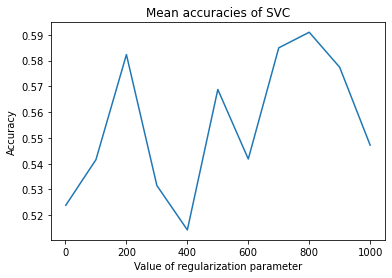

Max accuracy = 0.5909758672068238 for regularization = 800.0


In [51]:
regularizations = [1.0]
scoreMeans = []
reg = 100.0
while reg <= 1000.0:
    regularizations.append(reg)
    reg+=100.0
for reg in regularizations:
    print("Working on reg param {}...".format(reg))
    scores = evaluate_svc(X_train, y_train, X_test, reg, verbose=False)
    scoreMeans.append(scores.mean())
plt.plot(regularizations, scoreMeans)
plt.xlabel("Value of regularization parameter")
plt.ylabel("Accuracy")
plt.title("Mean accuracies of SVC")
plt.savefig('svm_svc_accuracies_1.png')
plt.show()
print("Max accuracy = {} for regularization = {}".format(max(scoreMeans), regularizations[scoreMeans.index(max(scoreMeans))]))

Second study of performances for values of C in [1.0, 100.0]

Working on reg param 1.0...
Working on reg param 10.0...
Working on reg param 20.0...
Working on reg param 30.0...
Working on reg param 40.0...
Working on reg param 50.0...
Working on reg param 60.0...
Working on reg param 70.0...
Working on reg param 80.0...
Working on reg param 90.0...
Working on reg param 100.0...


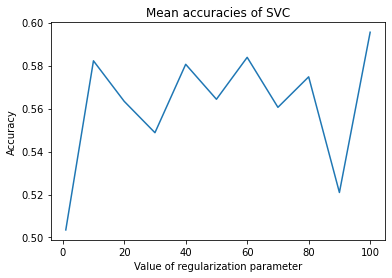

Max accuracy = 0.595527691362028 for regularization = 100.0


In [52]:
regularizations = [1.0]
scoreMeans = []
reg = 10.0
while reg <= 100.0:
    regularizations.append(reg)
    reg+=10.0
for reg in regularizations:
    print("Working on reg param {}...".format(reg))
    scores = evaluate_svc(X_train, y_train, X_test, reg, verbose=False)
    scoreMeans.append(scores.mean())
plt.plot(regularizations, scoreMeans)
plt.xlabel("Value of regularization parameter")
plt.ylabel("Accuracy")
plt.title("Mean accuracies of SVC")
plt.savefig('svm_svc_accuracies_2.png')
plt.show()
print("Max accuracy = {} for regularization = {}".format(max(scoreMeans), regularizations[scoreMeans.index(max(scoreMeans))]))

Third study of performances for values of C in [1.0, 20.0]

Working on reg param 1.0...
Working on reg param 3.0...
Working on reg param 5.0...
Working on reg param 7.0...
Working on reg param 9.0...
Working on reg param 11.0...
Working on reg param 13.0...
Working on reg param 15.0...
Working on reg param 17.0...
Working on reg param 19.0...


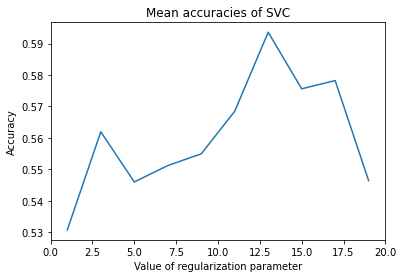

Max accuracy = 0.5935856987845591 for regularization = 13.0


In [53]:
regularizations = []
scoreMeans = []
reg = 1.0
while reg < 21.0:
    print("Working on reg param {}...".format(reg))
    regularizations.append(reg)
    scores = evaluate_svc(X_train, y_train, X_test, reg, verbose=False)
    scoreMeans.append(scores.mean())
    reg+=2.0
plt.plot(regularizations, scoreMeans)
plt.xlabel("Value of regularization parameter")
plt.ylabel("Accuracy")
plt.xlim((0, 20))
plt.title("Mean accuracies of SVC")
plt.savefig('svm_svc_accuracies_3.png')
plt.show()
print("Max accuracy = {} for regularization = {}".format(max(scoreMeans), regularizations[scoreMeans.index(max(scoreMeans))]))

Test of performances for given values of C

In [54]:
print("SVM C=10.0 = {}".format(evaluate_svc(X_train, y_train, X_test, 10.0, verbose=False).mean()))
print("SVM C=100.0 = {}".format(evaluate_svc(X_train, y_train, X_test, 100.0, verbose=False).mean()))
print("SVM C=1000.0 = {}".format(evaluate_svc(X_train, y_train, X_test, 1000.0, verbose=False).mean()))
print("SVM C=10000.0 = {}".format(evaluate_svc(X_train, y_train, X_test, 10000.0, verbose=False).mean()))

SVM C=10.0 = 0.596482862259368
SVM C=100.0 = 0.5760495633955228
SVM C=1000.0 = 0.5715470361209729
SVM C=10000.0 = 0.5475459589467512


One test where gamma = 'auto'

In [55]:
print("SVM - gamma auto = {}".format(evaluate_svc(X_train, y_train, X_test, 1.0, gamma='auto', verbose=False).mean()))

SVM - gamma auto = 0.03081469689487092


Thinner study of performances for values of C in [1.0, 120.0]

Working on reg param 1.0...
Working on reg param 10.0...
Working on reg param 20.0...
Working on reg param 30.0...
Working on reg param 40.0...
Working on reg param 50.0...
Working on reg param 60.0...
Working on reg param 70.0...
Working on reg param 80.0...
Working on reg param 90.0...
Working on reg param 100.0...
Working on reg param 110.0...
Working on reg param 120.0...


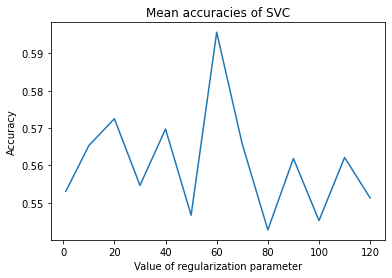

Max accuracy = 0.5956468368018641 for regularization = 60.0


In [59]:
regularizations = [1.0]
scoreMeans = []
reg = 10.0
while reg <= 120.0:
    regularizations.append(reg)
    reg+=10.0
for reg in regularizations:
    print("Working on reg param {}...".format(reg))
    scores = evaluate_svc(X_train, y_train, X_test, reg, nb_iter=20, verbose=False)
    scoreMeans.append(scores.mean())
plt.plot(regularizations, scoreMeans)
plt.xlabel("Value of regularization parameter")
plt.ylabel("Accuracy")
plt.title("Mean accuracies of SVC")
plt.savefig('svm_svc_accuracies_4.png')
plt.show()
print("Max accuracy = {} for regularization = {}".format(max(scoreMeans), regularizations[scoreMeans.index(max(scoreMeans))]))

Using a SVM with a regularization of 60 gives a high accuracy as we can see on the previous graph.
Thus, we will use a SVM (sklearn.svm.SVC) with a regularization of 60.